# Initial Setup

In [1]:
%%time

# Load packages.
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from statsmodels.graphics.tsaplots import plot_acf
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, contrast

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

CPU times: user 2.88 s, sys: 1.67 s, total: 4.55 s
Wall time: 1.37 s


# Laboratory

## Explore Smarket Data Set

In [2]:
# Load data.
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


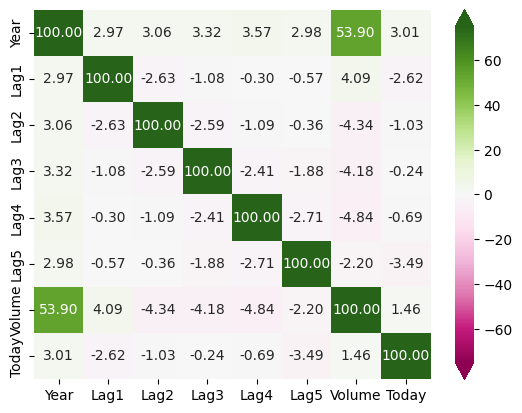

In [3]:
data = Smarket.drop(labels=["Direction"], axis=1).corr()
scale = 100
ax = sns.heatmap(
    data=scale * data,
    vmin=scale * -0.75,
    vmax=scale * 0.75,
    annot=True,
    fmt=".2f",
    cmap=plt.cm.PiYG,
    cbar_kws={"extend": "both"}
)

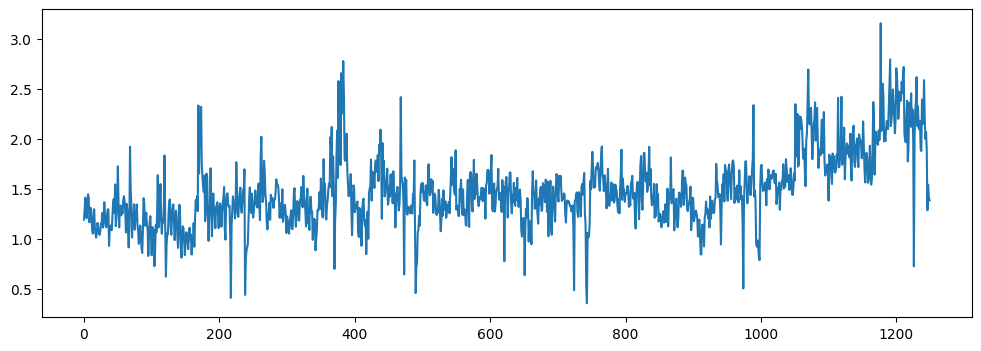

In [4]:
_ = Smarket.Volume.plot(figsize=(12, 4))

In [5]:
Smarket[Smarket.Direction == "Up"].shape

(648, 9)

In [6]:
Smarket[Smarket.Direction == "Down"].shape

(602, 9)

CPU times: user 2.69 s, sys: 2.1 s, total: 4.8 s
Wall time: 887 ms


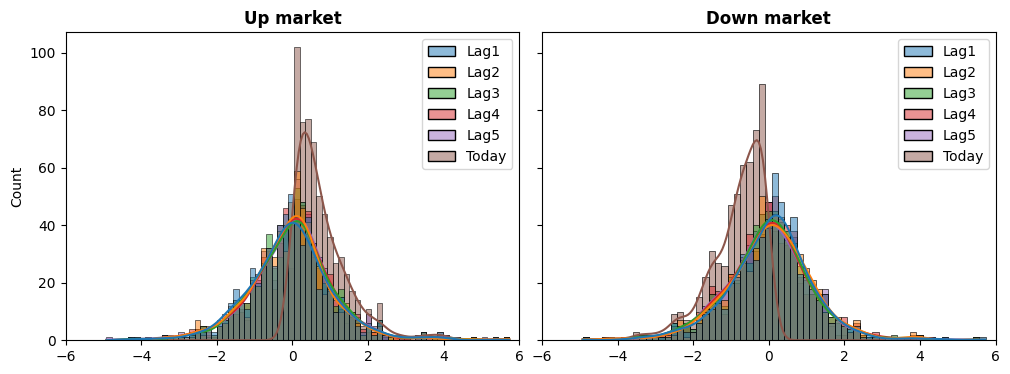

In [7]:
%%time

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.histplot(
    data=Smarket[Smarket.Direction == "Up"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[0]
)
sns.histplot(
    data=Smarket[Smarket.Direction == "Down"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[1]
)
axs[0].set_xlim((-6, 6))
axs[0].set_title("Up market", weight="bold")
_ = axs[1].set_title("Down market", weight="bold")
plt.subplots_adjust(wspace=0.05)

## Logistic regression

In [8]:
%%time 

predictors = Smarket.columns.drop (["Today", "Direction", "Year"])

design = MS(predictors)
Xp = design.fit_transform(Smarket)
y = (Smarket.Direction == "Up").astype(int)
glm = sm.GLM(
    endog=y,
    exog=Xp,
    family=sm.families.Binomial()
)
results = glm.fit()
summarize(results)

CPU times: user 83.3 ms, sys: 650 µs, total: 83.9 ms
Wall time: 83.3 ms


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [9]:
cut_prob = 0.5
nobs = Smarket.shape[0]

probs = results.predict ()
labels = np.array(nobs * ["Down"])
labels[probs > cut_prob] = "Up"

confusion_table(labels , Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [10]:
(507 + 145) /1250 , np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [11]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [12]:
X_train , X_test = Xp.loc[train], Xp.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [13]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [14]:
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [15]:
100 * np.mean(labels == L_test), 100 * np.mean(labels != L_test)

(48.01587301587302, 51.98412698412699)

In [16]:
model = MS(["Lag1", "Lag2"]).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array (252 * ["Down"])
labels[probs >0.5] = "Up"

confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [17]:
newdata = pd.DataFrame ({"Lag1": [1.2, 1.5], "Lag2": [1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

## Linear Discriminat Analysis

In [18]:
%%time

lda = LDA(store_covariance=True)

X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
lda.fit(X_train , L_train)

CPU times: user 3.52 ms, sys: 1.95 ms, total: 5.47 ms
Wall time: 5.19 ms


LinearDiscriminantAnalysis(store_covariance=True)

In [19]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [20]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [21]:
lda.priors_

array([0.49198397, 0.50801603])

In [22]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [23]:
lda_pred = lda.predict(X_test)
lda_prob = lda.predict_proba(X_test)
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [24]:
np.sum(lda_prob[:,0] > 0.9)

0

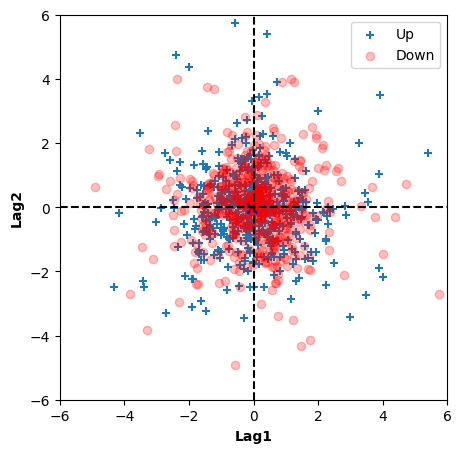

In [25]:
mask_up = y_train == 1
mask_down = y_train == 0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train[mask_up].iloc[:, 0], X_train[mask_up].iloc[:, 1], alpha=1, marker="+", label="Up")
ax.scatter(X_train[mask_down].iloc[:, 0], X_train[mask_down].iloc[:, 1], color="red", alpha=0.25, label="Down")
ax.scatter(lda.means_[1, 0], lda.means_[1, 1], color="blue", marker="x", s=50)
ax.scatter(lda.means_[0, 0], lda.means_[0, 1], color="red", marker="x", s=50)
ax.set_xlabel(X_train.columns[0], weight="bold")
ax.set_ylabel(X_train.columns[1], weight="bold")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))
ax.axvline(ls="--", color="black")
ax.axhline(ls="--", color="black")
_ = plt.legend()

## Quadratic Discriminant Analysis

In [26]:
qda = QDA( store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [27]:
qda.means_ , qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [28]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [29]:
qda.covariance_[1]

array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])

In [30]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [31]:
100 * np.mean(qda_pred == L_test)

59.92063492063492

## Naive Bayes

In [32]:
NB = GaussianNB ()
NB.fit(X_train, L_train)

GaussianNB()

In [33]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [34]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [35]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [36]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [37]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels , L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


## K-Nearest Neighbors

# Exercises

## Applied

### 13

**This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.**

In [38]:
df_weekly = load_data("Weekly")

# Show it.
df_weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


**(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?**

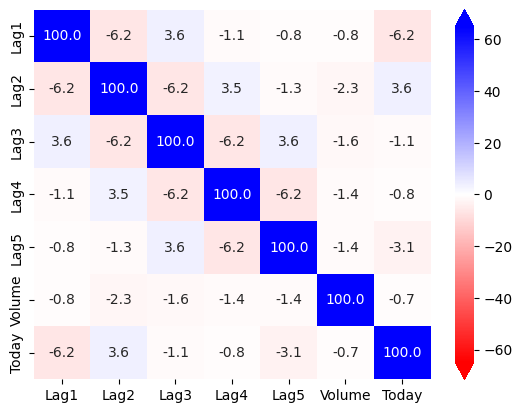

In [39]:
sns.heatmap(
    data=100 * df_weekly.drop(["Year", "Direction"], axis=1).corr(method="kendall"),
    vmin=100 * -0.65,
    vmax=100 * 0.65,
    cmap=plt.cm.bwr_r,
    annot=True,
    fmt=".1f",
    cbar_kws={"extend": "both"}
);

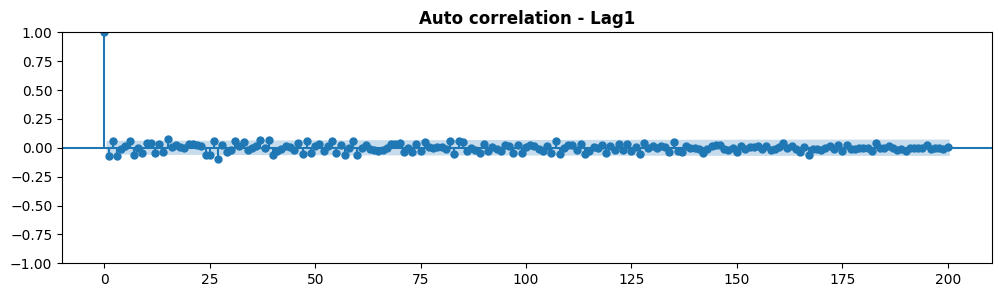

In [40]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_acf(x=df_weekly.Lag1, lags=200, ax=ax)
ax.set_title("Auto correlation - Lag1", weight="bold")
plt.show()

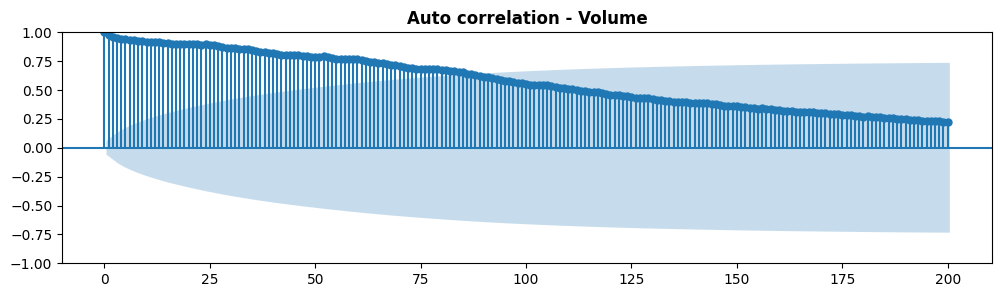

In [41]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_acf(x=df_weekly.Volume, lags=200, ax=ax)
ax.set_title("Auto correlation - Volume", weight="bold")
plt.show()

**(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?**

In [42]:
df_weekly["Direction_encoded"] = df_weekly["Direction"].map({"Down": 0, "Up": 1})

X = df_weekly.loc[:, ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]].copy(deep=True)
X = sm.add_constant(X)
y = df_weekly["Direction_encoded"].copy(deep=True)
results = sm.Logit(y, X).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      Direction_encoded   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                0.006580
Time:                        21:32:13   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

**(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.**

In [43]:
threshold = 0.5
y_pred = (results.predict(X) > threshold).astype(int).values

confusion_table(
    predicted_labels=pd.Series(y_pred).map({0: "Down", 1: "Up"}), 
    true_labels=y.map({0: "Down", 1: "Up"})
)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [44]:
cr = classification_report(
    y_pred=pd.Series(y_pred).map({0: "Down", 1: "Up"}),
    y_true=y.map({0: "Down", 1: "Up"})
)

print(cr)

              precision    recall  f1-score   support

        Down       0.53      0.11      0.18       484
          Up       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089

